<a href="https://colab.research.google.com/github/kmkolasinski/keras_detection/blob/master/notebooks/fpn_builder_random_rectangles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q --extra-index-url=https://test.pypi.org/simple/ tensorflow-model-optimization==0.3.0.dev6
! pip install --upgrade git+https://github.com/kmkolasinski/keras_detection.git

  Cloning https://github.com/kmkolasinski/keras_detection.git to /tmp/pip-req-build-hjf_d8xz
  Running command git clone -q https://github.com/kmkolasinski/keras_detection.git /tmp/pip-req-build-hjf_d8xz
  Created wheel for keras-detection: filename=keras_detection-0.1-cp36-none-any.whl size=71903 sha256=3b2da3f5f5df7962716ca793e94a7006f2bc48198b48916971a481392efcd24a
  Stored in directory: /tmp/pip-ephem-wheel-cache-rc201bn8/wheels/9c/23/23/2d3299a84b3beda7addbe5f17af1aa74b0e15fd87214803132
Successfully built keras-detection
  Found existing installation: keras-detection 0.1
    Uninstalling keras-detection-0.1:
      Successfully uninstalled keras-detection-0.1


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras_detection.models.box_detector import BoxDetectionOutput
import keras_detection.datasets.datasets_ops as datasets_ops
import keras_detection.datasets.random_rectangles as random_rects
from keras_detection import ImageData

In [0]:
keras = tf.keras

Random rectangles detection dataset

In [4]:
dataset = datasets_ops.from_numpy_generator(
    random_rects.create_random_rectangles_dataset_generator(min_max_num_boxes=(5, 20))
)
dataset

<FlatMapDataset shapes: {features: {image: (None, None, 3)}, labels: {boxes: (None, 4), labels: (None,), weights: (None,)}}, types: {features: {image: tf.uint8}, labels: {boxes: tf.float32, labels: tf.int64, weights: tf.float32}}>

In [0]:
# Benchmark dataset sampling
# %timeit next(iter(dataset))

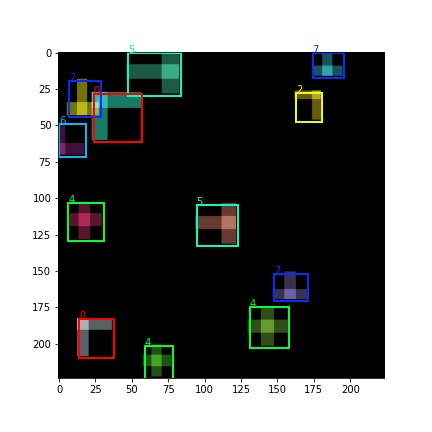

In [5]:
image_data = ImageData.from_dict(next(iter(dataset)))
image_frame_data = BoxDetectionOutput.from_tf_boxes(
    boxes=image_data.labels.boxes.numpy(),
    labels=image_data.labels.labels.numpy()
)
image_frame_data.draw(image_data.features.image.numpy())

# Build dataset (batched) and FPN detection model 

In [0]:
import keras_detection.datasets.datasets_ops as datasets_ops

def aug_fn(image_data: ImageData) -> ImageData:
    image = tf.cast(image_data.features.image, tf.float32)
    image = tf.image.random_brightness(image, max_delta=1.2)
    return image_data.replace_image(image)


image_dim = 224
batch_size = 32
shuffle_buffer_size = 1 # we don't have to shuffle random rectangles dataset
num_classes = 9 # random rectangles have 9 classes
num_parallel_calls = tf.data.experimental.AUTOTUNE

In [0]:
dataset = datasets_ops.from_numpy_generator(
    random_rects.create_random_rectangles_dataset_generator(image_size=(image_dim, image_dim), min_max_num_boxes=(5, 20))
)

train_dataset = datasets_ops.prepare_dataset(
    dataset,
    model_image_size=(image_dim, image_dim),
    augmentation_fn=aug_fn,
    num_epochs=-1,
    batch_size=batch_size ,
    shuffle_buffer_size=shuffle_buffer_size,
    prefetch_buffer_size=4,
    num_parallel_calls=num_parallel_calls
)

In [0]:
# %timeit next(iter(train_dataset))

# Build model builder 

In [0]:
from keras_detection import FPNBuilder
from keras_detection.tasks import standard_tasks
from keras_detection.backbones import resnet
from keras_detection.utils import plotting


backbone = resnet.ResNetBackbone(
    input_shape=(image_dim, image_dim, 3),
    units_per_block=(1, 1, 1),
    num_last_blocks=2, # number of feature pyramids
)

# Setting task quantizable to False will make that only the resnet backbone will be quantized
# other layers (tasks (heads) layers) will be trained in full precision.  

tasks = [
    # predicts objectnes score for each anchor
    standard_tasks.get_objectness_task(label_smoothing=0.02, obj_class="center_ignore_margin", quantizable=False),
    # predicts [height, with, y_center, x_center] location of the box
    standard_tasks.get_box_shape_task("box_shape", quantizable=False),
    # predicts [num_classes] for each anchor (focal loss is not supported yet)
    standard_tasks.get_multiclass_task(num_classes, fl_gamma=0.0, label_smoothing=0, activation='softmax', quantizable=False),
]

builder = FPNBuilder(backbone=backbone, tasks=tasks)

In [37]:
model = builder.build()

INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7fd38a677b00>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)
INFO:tensorflow: Processing feature map (fm14x14)


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 224, 224, 3) 0           image[0][0]                      
__________________________________________________________________________________________________
model (Model)                   [(None, 56, 56, 64), 1236178     tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
head/fm28x28/fm28x28/objectness (None, 28, 28, 1)    74113       model[1][1]                      
____________________________________________________________________________________________

In [0]:
# check resnet backbone
# model.layers[2].summary()

# Training model

In [0]:
prepared_train_dataset = train_dataset.map(builder.get_build_training_targets_fn())

In [19]:
prepared_train_dataset

<MapDataset shapes: ({image: (32, 224, 224, 3)}, {fm28x28/objectness: (32, 28, 28, 2), fm28x28/box_shape: (32, 28, 28, 5), fm28x28/classes: (32, 28, 28, 11), fm14x14/objectness: (32, 14, 14, 2), fm14x14/box_shape: (32, 14, 14, 5), fm14x14/classes: (32, 14, 14, 11)}), types: ({image: tf.float32}, {fm28x28/objectness: tf.float32, fm28x28/box_shape: tf.float32, fm28x28/classes: tf.float32, fm14x14/objectness: tf.float32, fm14x14/box_shape: tf.float32, fm14x14/classes: tf.float32})>

In [0]:
features, labels = next(iter(prepared_train_dataset))

Validating targets: objectness, box prediction and class predictions heads

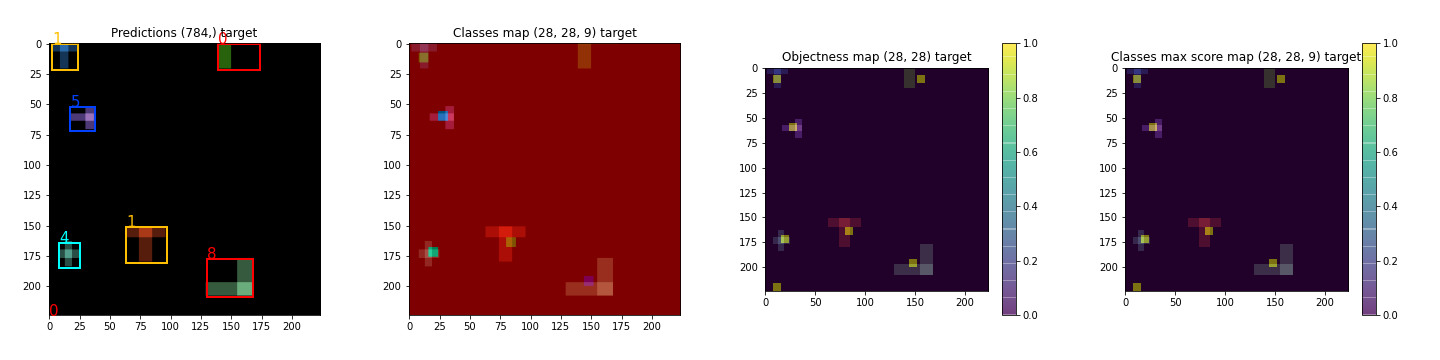

In [22]:
fm = "fm28x28"

targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
targets = builder.predictions_to_dict(targets, postprocess=True)

idx = 0
target=dict(
    objectness=targets[f'{fm}/objectness'][idx],
    boxes_shape_map=targets[f'{fm}/box_shape'][idx],
    classes_map=targets[f'{fm}/classes'][idx],
)

render = plotting.draw_compares(    
    target=target,
    predicted=None,
    all_targets=True,
    draw_fns=[
        plotting.draw_boxes, 
        plotting.draw_classes_map,
        plotting.draw_objectness_map,
        plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=0.2, 
)
render

Training standard detection model 

In [0]:
import keras_detection.models.utils as kd_utils

l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=model)
model.add_loss(l2_reg_fn)

In [26]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

Epoch 1/5
500/500 [==============================] - 95s 191ms/step - loss: 0.5757 - fm28x28/objectness_loss: 0.0283 - fm28x28/box_shape_loss: 0.0090 - fm28x28/classes_loss: 0.0277 - fm14x14/objectness_loss: 0.0470 - fm14x14/box_shape_loss: 0.0227 - fm14x14/classes_loss: 0.0714 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.1823 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9665 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9205 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0571 - fm28x28/classes_MulticlassAccuracyMetric: 0.8853 - fm14x14/objectness_ObjectnessPrecisionAT20pc: 0.2149 - fm14x14/objectness_ObjectnessRecallAT20pc: 0.9885 - fm14x14/objectness_ObjectnessPositivesMeanScore: 0.9602 - fm14x14/objectness_ObjectnessNegativesMeanScore: 0.1928 - fm14x14/classes_MulticlassAccuracyMetric: 0.8705
Epoch 2/5
500/500 [==============================] - 95s 191ms/step - loss: 0.4138 - fm28x28/objectness_loss: 0.0185 - fm28x28/box_shape_loss: 0.0064 - fm28x28/classes_loss:

In [0]:
!mkdir --parents models
model.save_weights("models/non-quantized-model.h5")

In [0]:
model.load_weights("models/non-quantized-model.h5")

# Test trained model

In [0]:
def draw_predictions(model, features, labels, idx = 0, fm = "fm28x28"):
  
  predictions = model.predict(features)
  predictions = builder.predictions_to_dict(predictions, postprocess=True)

  
  targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
  targets = builder.predictions_to_dict(targets, postprocess=True)

  target=dict(
      objectness=targets[f'{fm}/objectness'][idx],
      boxes_shape_map=targets[f'{fm}/box_shape'][idx],
      classes_map=targets[f'{fm}/classes'][idx],
  )

  predicted=dict(
      objectness=predictions[f'{fm}/objectness'][idx],
      boxes_shape_map=predictions[f'{fm}/box_shape'][idx],
      classes_map=predictions[f'{fm}/classes'][idx],
  )

  render = plotting.draw_compares(    
      target=target,
      predicted=predicted,
      draw_fns=[
          plotting.draw_boxes, 
          plotting.draw_classes_map,
          plotting.draw_objectness_map,
          plotting.draw_classes_max_score_map,
      ],
      image=features['image'][idx] / 255,
      score_threshold=0.5,
  )
  return render

# features, labels = next(iter(prepared_train_dataset))
# draw_predictions(model, features, labels, fm = "fm28x28")

Export model to tflite

In [34]:
len(_logger.handlers)

0

In [32]:
# Run this if you see tensorflow duplicated logs
from tensorflow.python.platform.tf_logging import _logger
if len(_logger.handlers) > 1:
  _logger.handlers.pop(0)

<StreamHandler stdout (NOTSET)>

In [33]:
# creates two versions of the model:  
#  - models/non-quantized-model.tflite
#  - models/non-quantized-model-quantized.tflite (for this representative dataset is used to accumulate stats)

exported_model, tflite_models_paths = builder.convert_to_tflite(    
    model, 
    save_path="models/non-quantized-model.tflite", 
    export_batch_size = 1,
    raw_dataset = dataset,  # dataset to the test the stats between (per image data)
    num_dataset_samples = 32, # representative dataset number of samples
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=True # Use represenetative dataset to create integer quantized model
)

INFO:tensorflow:Preparing dataset for export of quantized model
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness_1/Identity:0", shape=(1, 980), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape_1/Identity:0", shape=(1, 980, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes_1/Identity:0", shape=(1, 980, 9), dtype=float32)
INFO:tensorflow:Exporting model
INFO:tensorflow:Converting model to tflite format 
INFO:tensorflow:Building TFLite model from Keras Model using optimizations: [<Optimize.DEFAULT: 'DEFAULT'>]
INFO:tensorflow:Model converted successfully 
INFO:tensorflow:Testing tflite model for N=1 iterations ..
INFO:tensorflow:Test finished in 0.105418 seconds
INFO:tensorflow:Model saved to models/non-quantized-model.tflite
INFO:tensorflow:Converting quantized model


Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([  1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}
Output details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 103,
  'name': 'export/box_shape/output',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 980,   4], dtype=int32),
  'shape_signature': array([  1, 980,   4], dtype=int32),
  'sparsity_parameters': {}}
{ 'dtype': <class 'numpy.float32'>,
  'index': 109,
  'name': 'export/classes/output'

INFO:tensorflow:Model converted successfully 
INFO:tensorflow:Testing tflite model for N=1 iterations ..


Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 122,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([  1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}
Output details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 123,
  'name': 'export/box_shape/output',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 980,   4], dtype=int32),
  'shape_signature': array([  1, 980,   4], dtype=int32),
  'sparsity_parameters': {}}
{ 'dtype': <class 'numpy.float32'>,
  'index': 124,
  'name': 'export/classes/outpu

INFO:tensorflow:Test finished in 3.025844 seconds
INFO:tensorflow:Quantized model saved to models/non-quantized-model.quantized.tflite
INFO:tensorflow:Testing converted model: non-quantized-model.tflite
INFO:tensorflow:Testing converted model: non-quantized-model.tflite
100%|██████████| 16/16 [00:02<00:00,  6.14it/s]
INFO:tensorflow:Measured deviation between keras and tflite model:
INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.001443 
	RMSE    =  0.007112 
	Keras   = N(μ=  0.061984, σ=  0.212396)
	tflite  = N(μ=  0.062167, σ=  0.212732)
 - export/box_shape/output   
	MAE     =  0.001059 
	RMSE    =  0.001693 
	Keras   = N(μ=  0.277584, σ=  0.299346)
	tflite  = N(μ=  0.277790, σ=  0.299278)
 - export/classes/output     
	MAE     =  0.000053 
	RMSE    =  0.000971 
	Keras   = N(μ=  0.002409, σ=  0.042256)
	tflite  = N(μ=  0.002411, σ=  0.042299)
INFO:tensorflow:Testing converted model: non-quantized-model.quantized.tflite
INFO:tensorflow:Testing converted model: non-quanti

In [35]:
tflite_models_paths

[PosixPath('models/non-quantized-model.tflite'),
 PosixPath('models/non-quantized-model.quantized.tflite')]

Build and train Quantized model

In [38]:
quantized_model = builder.build_quantized(
    batch_size=None, 
    non_quantized_model_weights="models/non-quantized-model.h5"
)

INFO:tensorflow:Building quantized model with batch_size = None
INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7fd38a677b00>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)
INFO:tensorflow: Processing feature map (fm14x14)
INFO:tensorflow:Loading weights of base model: models/non-quantized-model.h5
INFO:tensorflow:Building graph with quantization enabled
INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7fd38a677b00>
INFO:tensorflow:Running quantization for model backbone: model_2
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)
INFO:tensorflow: Processing feature map (fm14x14)


In [40]:
# heads are not quantized (they have quantizable = Fales)
quantized_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_7 (TensorFl [(None, 224, 224, 3) 0           image[0][0]                      
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 56, 56, 64), 1239072     tf_op_layer_RealDiv_7[0][0]      
__________________________________________________________________________________________________
head/fm28x28/fm28x28/objectness (None, 28, 28, 1)    74113       model_2[1][1]                    
____________________________________________________________________________________________

In [42]:
# check if resnet is quantized
quantized_model.layers[2].summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           image[0][0]                      
__________________________________________________________________________________________________
quant_conv0-pre (QuantizeWrappe (None, 224, 224, 3)  16          quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_bn_data (QuantizeWrapper) (None, 224, 224, 3)  12          quant_conv0-pre[0][0]            
____________________________________________________________________________________________

In [43]:
# test metrics after quantization, they should be worse
# we can evaluate on train dataset since every batch is different
builder.evaluate_model(quantized_model, train_dataset, 100)

100/100 [==============================] - 15s 146ms/step - loss: 0.5993 - fm28x28/objectness_loss: 0.0278 - fm28x28/box_shape_loss: 0.0230 - fm28x28/classes_loss: 0.0199 - fm14x14/objectness_loss: 0.0513 - fm14x14/box_shape_loss: 0.0215 - fm14x14/classes_loss: 0.0555 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.3046 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9622 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.8015 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0237 - fm28x28/classes_MulticlassAccuracyMetric: 0.9094 - fm14x14/objectness_ObjectnessPrecisionAT20pc: 0.3403 - fm14x14/objectness_ObjectnessRecallAT20pc: 0.9957 - fm14x14/objectness_ObjectnessPositivesMeanScore: 0.9402 - fm14x14/objectness_ObjectnessNegativesMeanScore: 0.0901 - fm14x14/classes_MulticlassAccuracyMetric: 0.9124


[0.599277675151825,
 0.027774987742304802,
 0.022959422320127487,
 0.019886892288923264,
 0.05128651484847069,
 0.021526236087083817,
 0.055472735315561295,
 0.3045794367790222,
 0.9621999263763428,
 0.8015458583831787,
 0.023652559146285057,
 0.909427285194397,
 0.34028854966163635,
 0.9956534504890442,
 0.9402021169662476,
 0.09013652801513672,
 0.9123715758323669]

In [0]:
# quantized_model.metrics_names

In [0]:
l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=quantized_model)
quantized_model.add_loss(l2_reg_fn)

In [47]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=2, steps_per_epoch=500)
quantized_model.save_weights("models/quantized-model.h5")

500/500 [==============================] - 173s 346ms/step - loss: 0.4293 - fm28x28/objectness_loss: 0.0181 - fm28x28/box_shape_loss: 0.0078 - fm28x28/classes_loss: 0.0138 - fm14x14/objectness_loss: 0.0444 - fm14x14/box_shape_loss: 0.0190 - fm14x14/classes_loss: 0.0462 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2245 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9713 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9372 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0419 - fm28x28/classes_MulticlassAccuracyMetric: 0.9408 - fm14x14/objectness_ObjectnessPrecisionAT20pc: 0.2438 - fm14x14/objectness_ObjectnessRecallAT20pc: 0.9894 - fm14x14/objectness_ObjectnessPositivesMeanScore: 0.9628 - fm14x14/objectness_ObjectnessNegativesMeanScore: 0.1614 - fm14x14/classes_MulticlassAccuracyMetric: 0.9184
Epoch 2/2
500/500 [==============================] - 172s 344ms/step - loss: 0.3903 - fm28x28/objectness_loss: 0.0180 - fm28x28/box_shape_loss: 0.0068 - fm28x28/classes_loss: 0.0134 

In [0]:
quantized_model.save_weights("models/quantized-model.h5")

In [0]:
quantized_model.load_weights("models/quantized-model.h5")

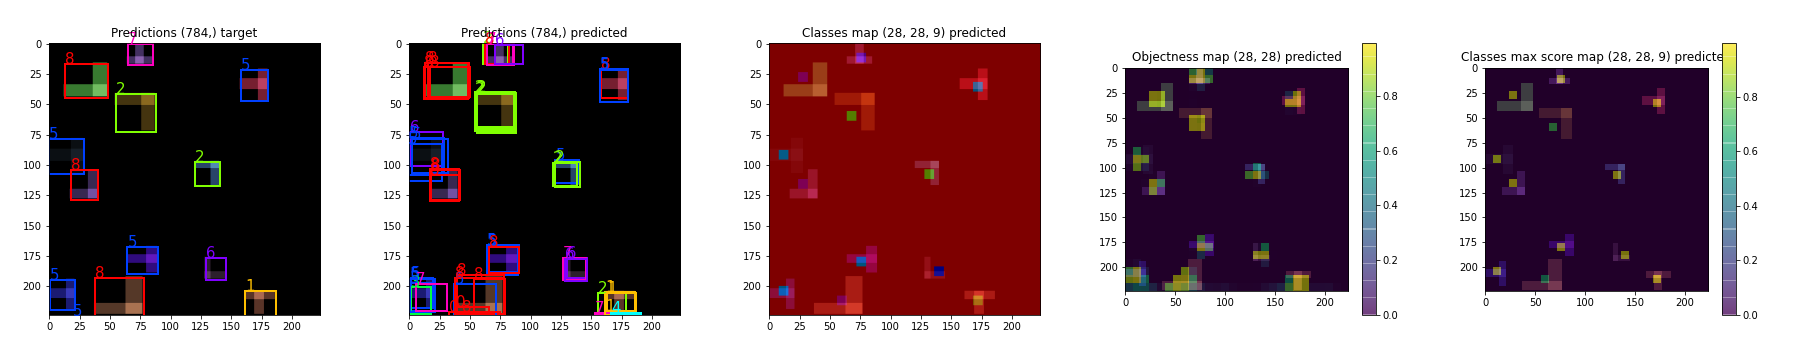

In [53]:
# features, labels = next(iter(prepared_train_dataset))
draw_predictions(quantized_model, features, labels, fm = "fm28x28")

In [0]:
# draw_predictions(quantized_model, features, labels, fm = "fm14x14")

In [57]:
builder.evaluate_model(quantized_model, train_dataset, 100)

100/100 [==============================] - 15s 145ms/step - loss: 0.3698 - fm28x28/objectness_loss: 0.0184 - fm28x28/box_shape_loss: 0.0062 - fm28x28/classes_loss: 0.0143 - fm14x14/objectness_loss: 0.0441 - fm14x14/box_shape_loss: 0.0137 - fm14x14/classes_loss: 0.0481 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2157 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9733 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9485 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0456 - fm28x28/classes_MulticlassAccuracyMetric: 0.9409 - fm14x14/objectness_ObjectnessPrecisionAT20pc: 0.2294 - fm14x14/objectness_ObjectnessRecallAT20pc: 0.9898 - fm14x14/objectness_ObjectnessPositivesMeanScore: 0.9696 - fm14x14/objectness_ObjectnessNegativesMeanScore: 0.1854 - fm14x14/classes_MulticlassAccuracyMetric: 0.9150


[0.3698403537273407,
 0.018394822254776955,
 0.006242021918296814,
 0.01433426234871149,
 0.044148679822683334,
 0.013673944398760796,
 0.04810294136404991,
 0.21572260558605194,
 0.9732905030250549,
 0.9485495090484619,
 0.045578837394714355,
 0.9408653378486633,
 0.22935806214809418,
 0.9898295402526855,
 0.9695593118667603,
 0.18540377914905548,
 0.9150264263153076]

In [59]:
# creates two versions of the model:  
#  - models/quantized-model.tflite

exported_model, quantized_tflite_models_paths = builder.convert_to_tflite(    
    quantized_model, 
    save_path="models/quantized-model.tflite", 
    export_batch_size = 1,
    raw_dataset = dataset,  # dataset to the test the stats between 
    num_dataset_samples = 32, # representative dataset number of samples
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=False # does not work with  QAT models
)

INFO:tensorflow:Preparing dataset for export of quantized model
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness_2/Identity:0", shape=(1, 980), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape_2/Identity:0", shape=(1, 980, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes_2/Identity:0", shape=(1, 980, 9), dtype=float32)
INFO:tensorflow:Exporting model
INFO:tensorflow:Converting model to tflite format 
INFO:tensorflow:Building TFLite model from Keras Model using optimizations: [<Optimize.DEFAULT: 'DEFAULT'>]
INFO:tensorflow:Model converted successfully 
INFO:tensorflow:Testing tflite model for N=1 iterations ..
INFO:tensorflow:Test finished in 0.107266 seconds
INFO:tensorflow:Model saved to models/quantized-model.tflite
INFO:tensorflow:Testing converted model: quantized-model.tflite
INFO:tensorflow:Testing converted model: quantized-model.tflite
  0%|        

Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([  1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}
Output details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 155,
  'name': 'export/box_shape/output',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 980,   4], dtype=int32),
  'shape_signature': array([  1, 980,   4], dtype=int32),
  'sparsity_parameters': {}}
{ 'dtype': <class 'numpy.float32'>,
  'index': 161,
  'name': 'export/classes/output'

100%|██████████| 16/16 [00:03<00:00,  4.88it/s]
INFO:tensorflow:Measured deviation between keras and tflite model:
INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.002851 
	RMSE    =  0.014105 
	Keras   = N(μ=  0.072896, σ=  0.232952)
	tflite  = N(μ=  0.075414, σ=  0.236108)
 - export/box_shape/output   
	MAE     =  0.002254 
	RMSE    =  0.003083 
	Keras   = N(μ=  0.280684, σ=  0.298870)
	tflite  = N(μ=  0.279462, σ=  0.299455)
 - export/classes/output     
	MAE     =  0.000061 
	RMSE    =  0.001134 
	Keras   = N(μ=  0.002007, σ=  0.039090)
	tflite  = N(μ=  0.002017, σ=  0.039056)
